# Is it possible to predict stock market?
![img_gpw_1.jpg](img_gpw_1.jpg)
# In this project I will:
* download from yahoo module and proccess data for WIG20 and others
* analyze basic attributes of indexes
* look for correlated indecies, commodities, currencies
* use neural netowork like lstm, or ARIMA for preditions
* draw conclusions

# 1. **Introductions in the stock markets**
The stock market, is a dynamic environment where investors purchase and sell shares and other financial instruments. The prices of these assets fluctuate constantly depending on daily trading activity and the impact of global events. Predicting these movements is extremely difficult because of the multitude of factors such as economic data, political decisions, corporate earnings and investor psychology.
Additionally, global money flows play an important role by linking different markets into groups, such as emerging markets and developed markets. The movement of capital between regions of the world affected by local wars affect as well. These complex relationships and global capital flows make stock market analysis an even more fascinating challenge.
# 2. **Collecting data**
The process of collecting data in stock markets is a key step in analysis and modeling. Investors and financial analysts use a variety of data sources such as financial API, market data providers and publicly available sources to obtain information about stock prices, stock indices, commodities and currencies.
8In this project, I will utilize Yahoo Finance, which provides free access for personal use only, allowing up to a total of 48,000 requests per day. This is likely one of the best free solutions available at the moment.

In [9]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from prophet import Prophet

symbols = pd.read_csv("tickers_symbols.csv")
tickers_list = symbols["ticker"].tolist()

In [10]:
df = yf.download(tickers_list, start="2020-01-01")
df = df["Adj Close"]

[*********************100%%**********************]  132 of 132 completed


In [11]:
symbols = symbols.set_index('ticker')['name']

In [12]:
print(df.isnull().sum())

000001.SS    469
399001.SZ    469
6A=F         431
6B=F         431
6C=F         431
            ... 
^TNX         431
^TWII        466
^TYX         431
^VIX         431
^XAX         432
Length: 132, dtype: int64


In [13]:
percentage_missing = (df.isnull().sum() / len(df)) * 100
percentage_missing = percentage_missing.sort_values(ascending=False)
print(percentage_missing)

OJ=F         61.660650
ETH=F        51.119134
LBS=F        38.772563
399001.SZ    33.862816
000001.SS    33.862816
               ...    
THB=X        28.592058
EURUSD=X     28.592058
GBPJPY=X     28.592058
BTC-USD       0.000000
ETH-USD       0.000000
Length: 132, dtype: float64


In [14]:
threshold = 40  # Percentage threshold
columns_to_drop = percentage_missing[percentage_missing > threshold].index
df=df.drop(columns=columns_to_drop)

In [15]:
df.ffill(inplace=True)
print(df.isnull().any().sum())
df.dropna(inplace=True)
print(df.isnull().any().sum())

101
0


In [16]:
df_pct = df.pct_change().dropna()

In [17]:
std_dev=df_pct.std()

print("lowest variability")
lowest_std=std_dev.nsmallest(10)
print(lowest_std)

print("higest variability")
highest_std=std_dev.nlargest(10)
print(highest_std)

lowest variability
HKD=X       0.000345
ZQ=F        0.000456
ZT=F        0.000991
ZF=F        0.002294
SGD=X       0.002439
MYR=X       0.002554
EURCHF=X    0.002756
CNY=X       0.002865
INR=X       0.003174
ZN=F        0.003362
dtype: float64
higest variability
^MERV      0.515484
RUB=X      0.388210
^IRX       0.324926
CL=F       0.094501
^VIX       0.068612
ETH-USD    0.046243
^FVX       0.045313
NG=F       0.040117
^TNX       0.036782
BTC-USD    0.035286
dtype: float64


In [18]:
print("The lowest variability:")
for idx, row in lowest_std.reset_index().iterrows():
    print("\t",idx+1,row.iloc[0],symbols[row.iloc[0]],"-",round(row.iloc[1],4))

The lowest variability:
	 1 HKD=X USD/HKD - 0.0003
	 2 ZQ=F 30 Day Fed Fund - 0.0005
	 3 ZT=F 2-Year T-Note Futures,Dec-2023 - 0.001
	 4 ZF=F Five-Year US Treasury Note Futu - 0.0023
	 5 SGD=X USD/SGD - 0.0024
	 6 MYR=X USD/MYR - 0.0026
	 7 EURCHF=X EUR/CHF - 0.0028
	 8 CNY=X USD/CNY - 0.0029
	 9 INR=X USD/INR - 0.0032
	 10 ZN=F 10-Year T-Note Futures,Dec-2023 - 0.0034


In [19]:
print("The highest variability:")
for idx, row in highest_std.reset_index().iterrows():
    print("\t",idx+1,row.iloc[0],symbols[row.iloc[0]],"-",round(row.iloc[1],4))

The highest variability:
	 1 ^MERV MERVAL - 0.5155
	 2 RUB=X USD/RUB - 0.3882
	 3 ^IRX 13 WEEK TREASURY BILL - 0.3249
	 4 CL=F Crude Oil - 0.0945
	 5 ^VIX CBOE VIX Futures - 0.0686
	 6 ETH-USD Ethereum USD - 0.0462
	 7 ^FVX Treasury Yield 5 Years - 0.0453
	 8 NG=F Natural Gas Nov 23 - 0.0401
	 9 ^TNX Treasury Yield 10 Years - 0.0368
	 10 BTC-USD Bitcoin USD - 0.0353


In [20]:
first_price = df.iloc[0]
last_price = df.iloc[-1]
returns = (last_price / first_price - 1) * 100
top_10_returns = returns.nlargest(10)
bottom_10_returns = returns.nsmallest(10)

print("The highest return:")
idx=0
for ticker,profit in top_10_returns.items():
    idx+=1
    print("\t",idx,profit," - ",symbols[ticker],ticker)

print("The lowest return:")
idx=0
for ticker,profit in bottom_10_returns.items():
    idx+=1
    print("\t",idx,profit," - ",symbols[ticker],ticker)
    

The highest return:
	 1 1734.2882317219  -  MERVAL ^MERV
	 2 998.2994500332395  -  Ethereum USD ETH-USD
	 3 259.55880832569886  -  Bitcoin USD BTC-USD
	 4 258.0645122525596  -  13 WEEK TREASURY BILL ^IRX
	 5 190.62696022886408  -  Treasury Yield 5 Years ^FVX
	 6 158.91773367538698  -  Treasury Yield 10 Years ^TNX
	 7 112.6698836975096  -  Treasury Yield 30 Years ^TYX
	 8 95.84850900343599  -  Sugar #11 Mar 24 SB=F
	 9 84.19988133574965  -  S&P Information Technology ^SP500-45
	 10 80.31129193014648  -  NYSE AMEX COMPOSITE INDEX ^XAX
The lowest return:
	 1 -98.73273509394318  -  Rough Rice Futures,Jan-2024 ZR=F
	 2 -42.721424247714246  -  Palladium Dec 23 PA=F
	 3 -37.50357481198374  -  HANG SENG INDEX ^HSI
	 4 -31.55086824969541  -  iShares 20+ Year Treasury Bond ETF (TLT)  TLT
	 5 -30.0079951060822  -  iShares MSCI China ETF MCHI
	 6 -29.281330429617903  -  U.S. Treasury Bond Futures,Dec- ZB=F
	 7 -27.767818368529106  -  Yapanese Yen JPYUSD=X
	 8 -16.924564796905216  -  10-Year T-Note

In [21]:
df.ffill(inplace=True)
print(df.isnull().any().sum())
df.dropna(inplace=True)
print(df.isnull().any().sum())

0
0


In [22]:
corr_matrix = df.corr()
corr_epol=corr_matrix["EPOL"].sort_values(ascending=False)

In [23]:
top_corr=corr_epol[1:10]
bottom_corr=corr_epol[-10:]
bottom_corr=bottom_corr[::-1]

In [24]:
print("Top positive correlated:")
print(top_corr)

print("Top positive correlated:")
print(bottom_corr)

Top positive correlated:
IMOEX.ME    0.857905
6B=F        0.824075
GBPUSD=X    0.819068
CZK=F       0.809547
EFA         0.791129
EEM         0.754511
^NZ50       0.738241
MME=F       0.737101
^KS11       0.722179
Name: EPOL, dtype: float64
Top positive correlated:
SGD=X      -0.653967
DX-Y.NYB   -0.647576
CHF=X      -0.608816
^VIX       -0.588671
IDR=X      -0.556579
EURHUF=X   -0.550861
ZAR=X      -0.517479
CNY=X      -0.514888
MYR=X      -0.453382
PHP=X      -0.448682
Name: EPOL, dtype: float64


In [25]:
print("The highest return:")
idx=0
for ticker,profit in top_corr.items():
    idx+=1
    print("\t",idx,round(profit,4)," - ",symbols[ticker],ticker)

print("The lowest return:")
idx=0
for ticker,profit in bottom_corr.items():
    idx+=1
    print("\t",idx,round(profit,4)," - ",symbols[ticker],ticker)

The highest return:
	 1 0.8579  -  MOEX Russia Index IMOEX.ME
	 2 0.8241  -  British Pound 6B=F
	 3 0.8191  -  GBP/USD GBPUSD=X
	 4 0.8095  -  Czech Koruna Futures,Dec-2023 CZK=F
	 5 0.7911  -  iShares MSCI EAFE ETF EFA
	 6 0.7545  -  iShares MSCI Emerging Markets ETF EEM
	 7 0.7382  -  S&P/NZX 50 INDEX GROSS  ^NZ50
	 8 0.7371  -  MSCI Emerging Markets Index Futures MME=F
	 9 0.7222  -  KOSPI Composite Index ^KS11
The lowest return:
	 1 -0.654  -  USD/SGD SGD=X
	 2 -0.6476  -  USD Index DX-Y.NYB
	 3 -0.6088  -  Swiss Franc CHF=X
	 4 -0.5887  -  CBOE VIX Futures ^VIX
	 5 -0.5566  -  USD/IDR IDR=X
	 6 -0.5509  -  EUR/HUF EURHUF=X
	 7 -0.5175  -  USD/ZAR ZAR=X
	 8 -0.5149  -  USD/CNY CNY=X
	 9 -0.4534  -  USD/MYR MYR=X
	 10 -0.4487  -  USD/PHP PHP=X


The most pronounced correlation is observed between EPOL and the EUR/USD exchange rate. This relationship is justified, considering that capital tends to flow into Poland when the Polish index records increases, elsewhere there are etf iShares MSCI EAFE ETF (MSCI Europe, Australasia and the Far East), European currencies such as the Euro/Dolar , British Pound, Czech Koruna, over American Index SP500 – the American index is the most influential market index in the world, and others are related to our market index through geographical proximity or market similars.

On the other hand, the most negatively correlated indices, with correlation coefficients below -0.6, include the U.S. Dollar, the Hungarian Forint/Euro, the Swiss Franc, and other currencies in relation to the Dollar. This indicates the strength of these currencies and their role as a safe haven during times of risk in contrast to the more volatile Polish developing market.

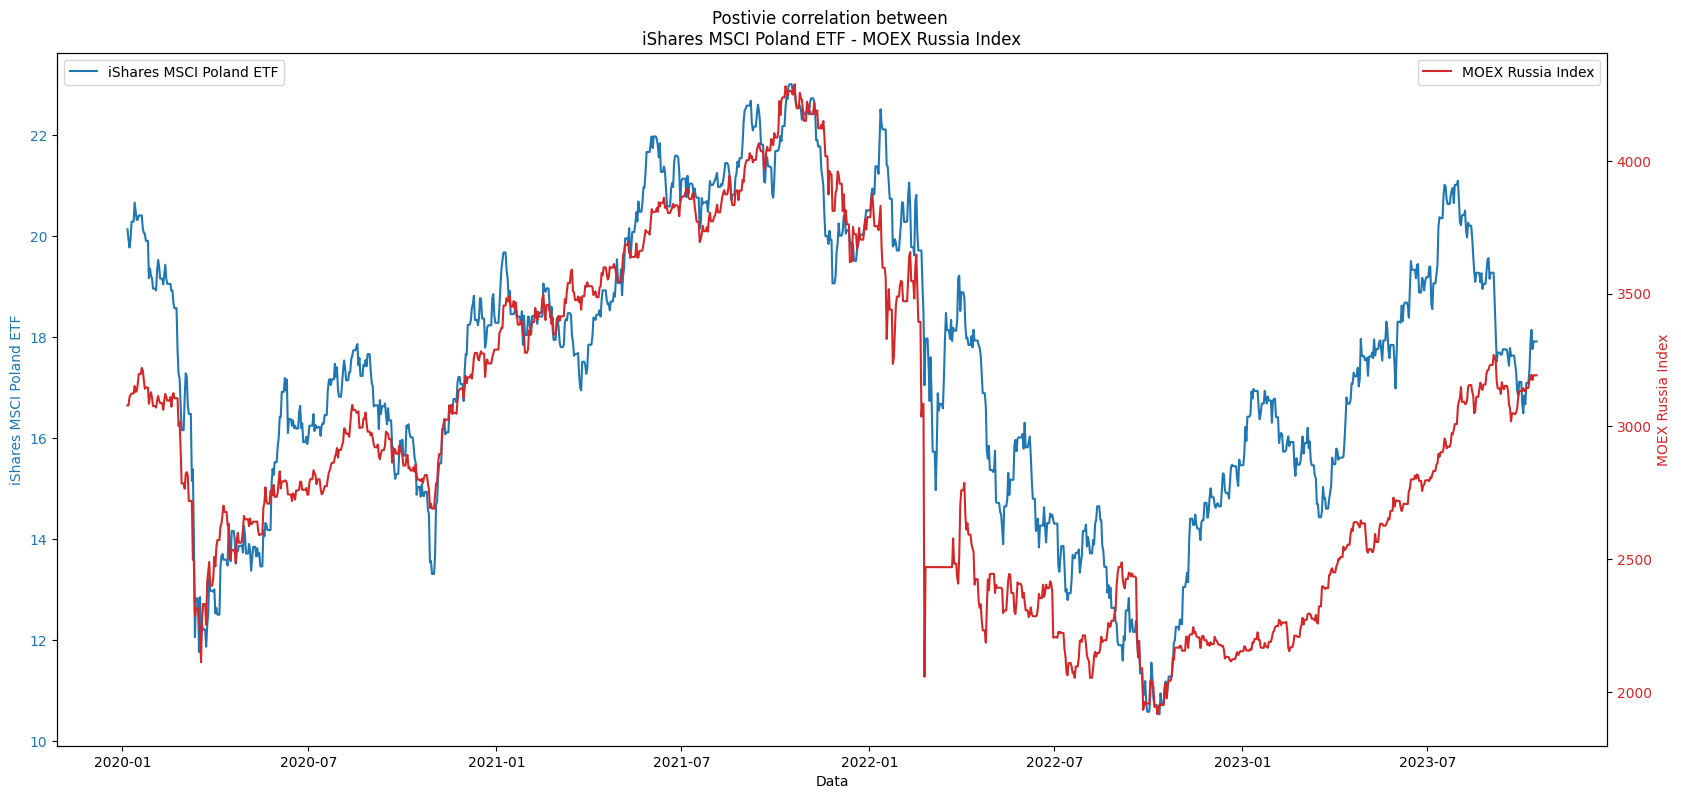

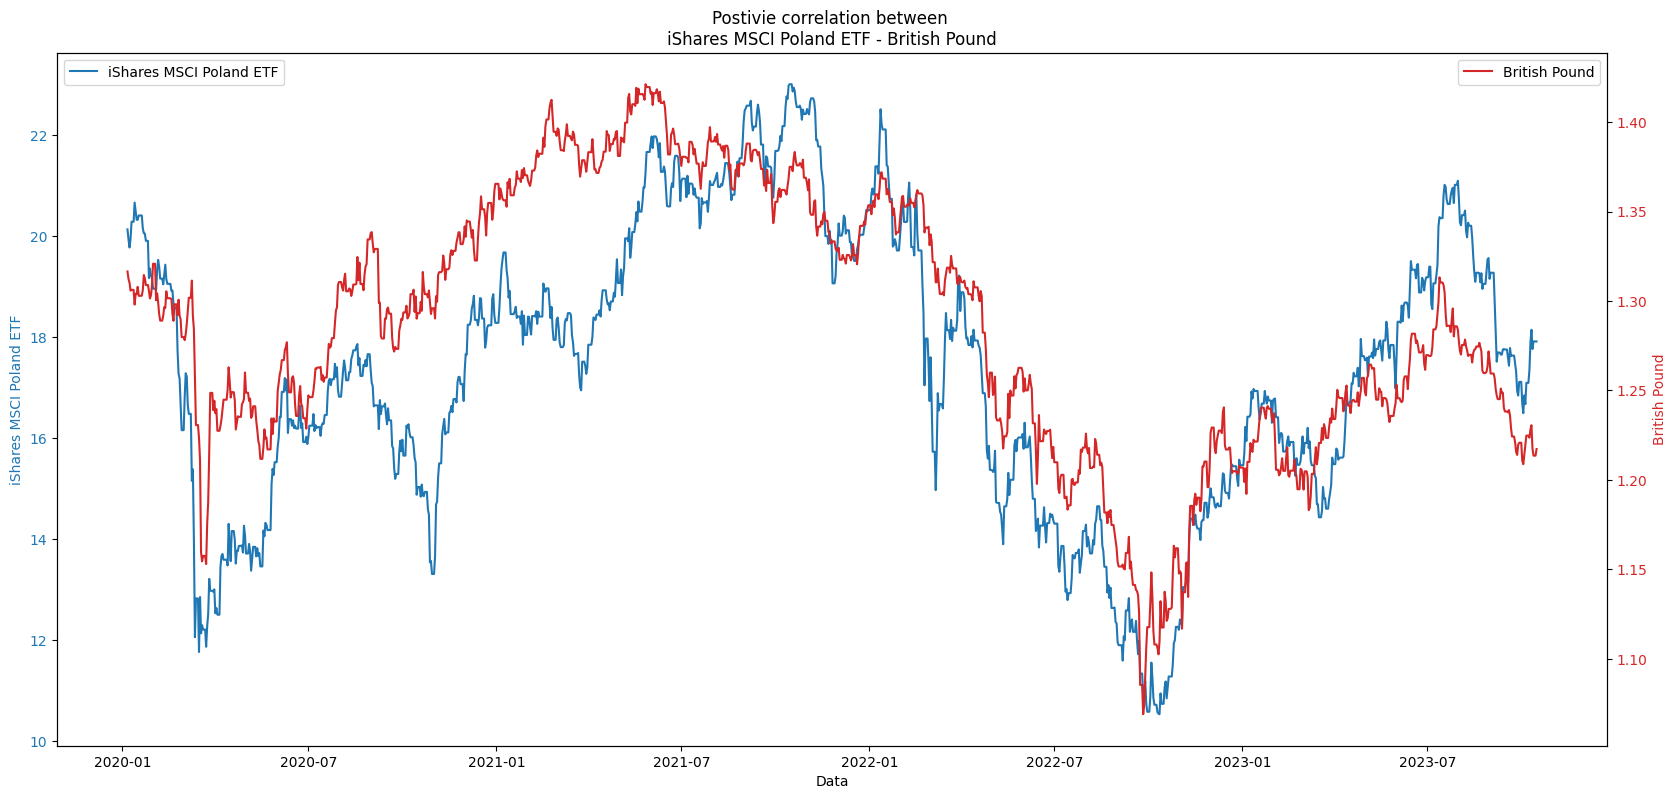

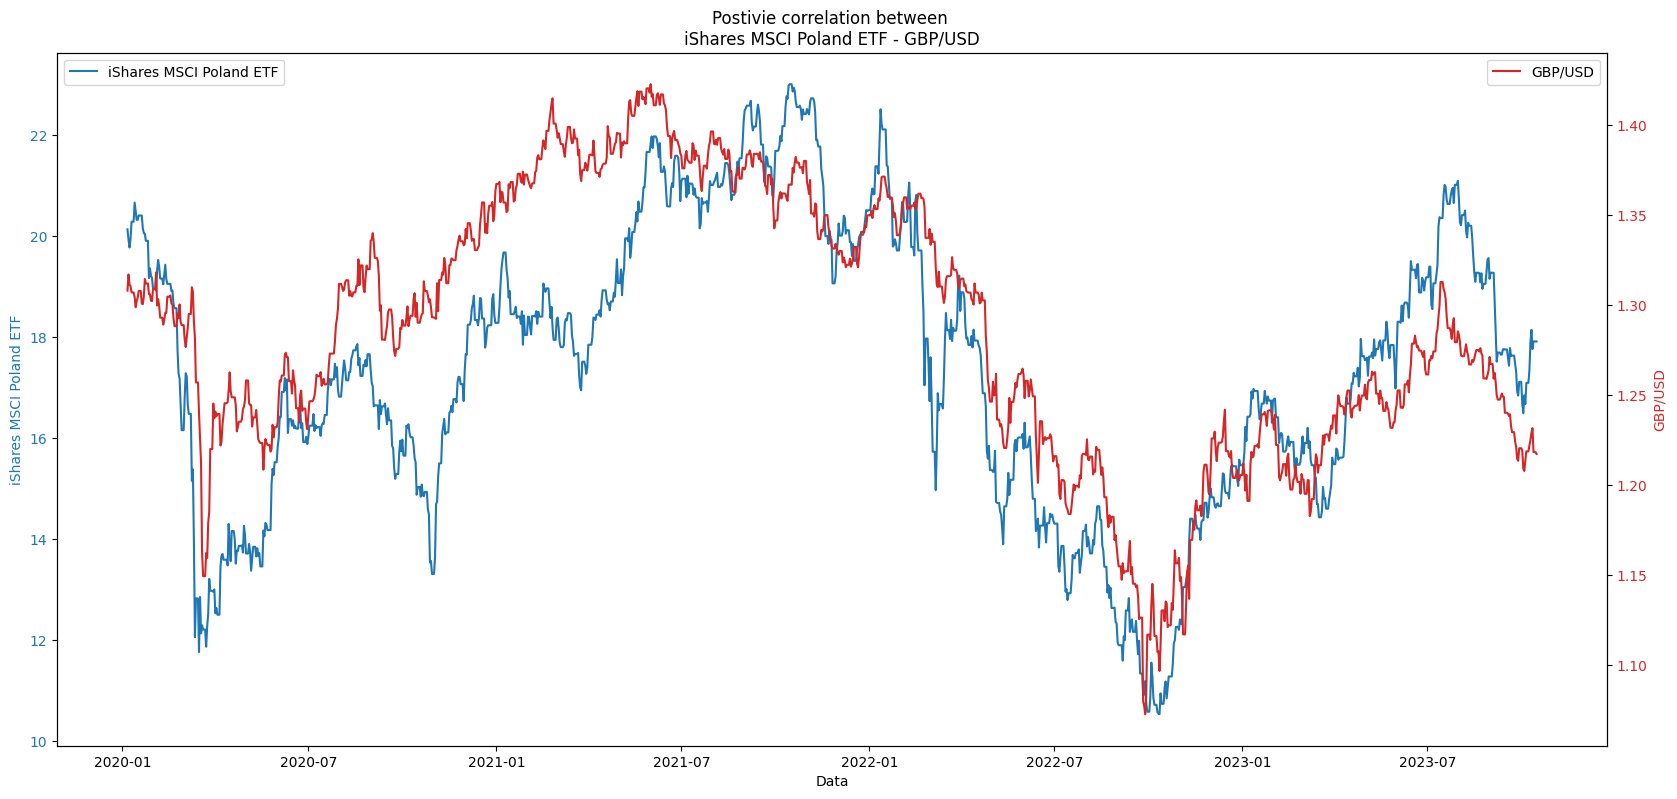

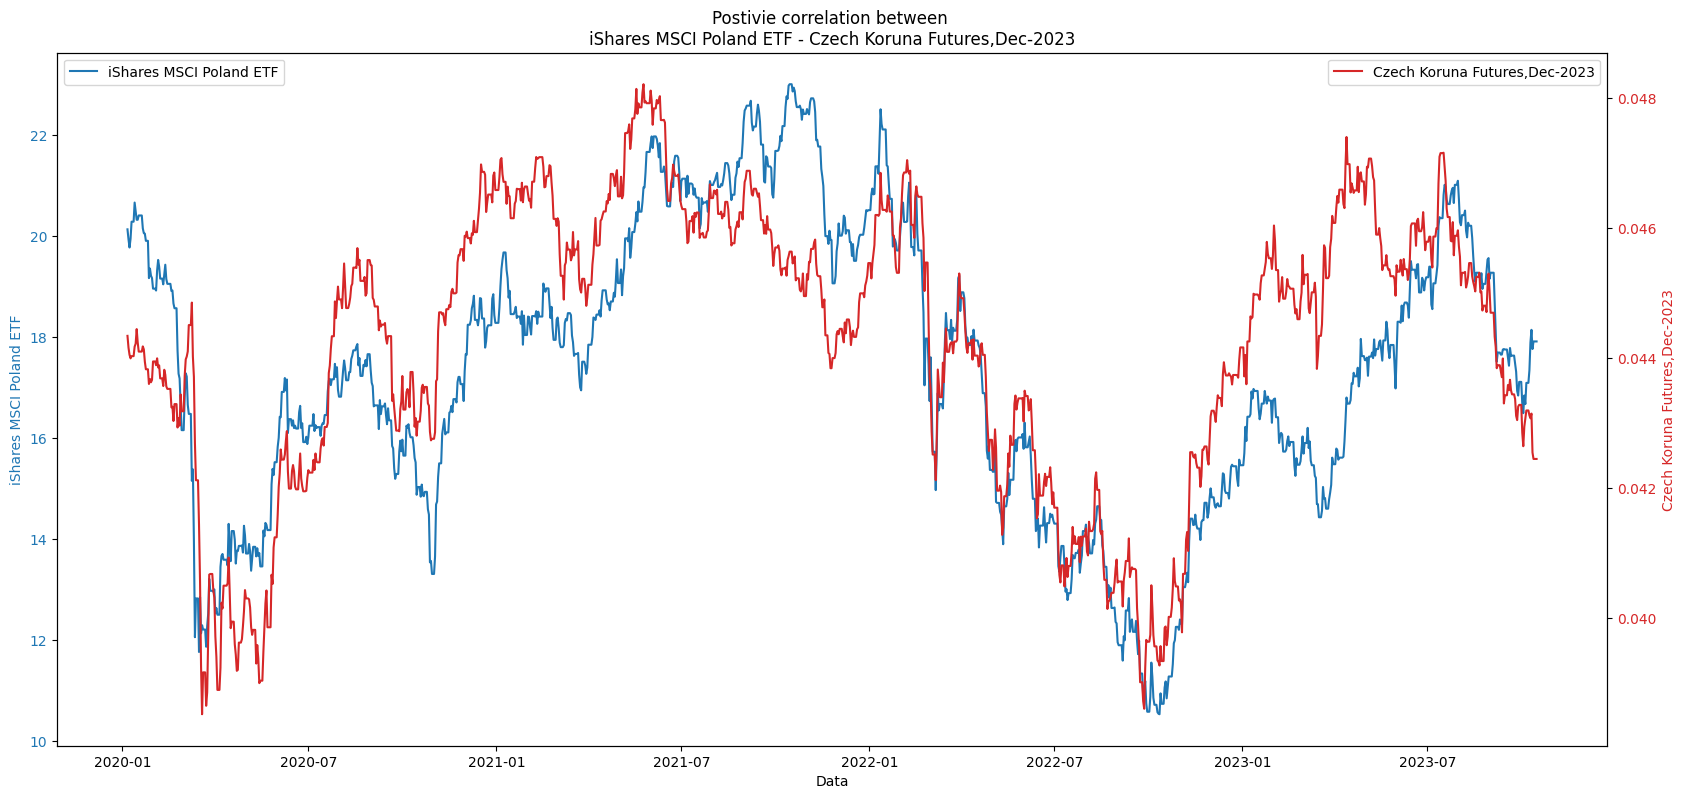

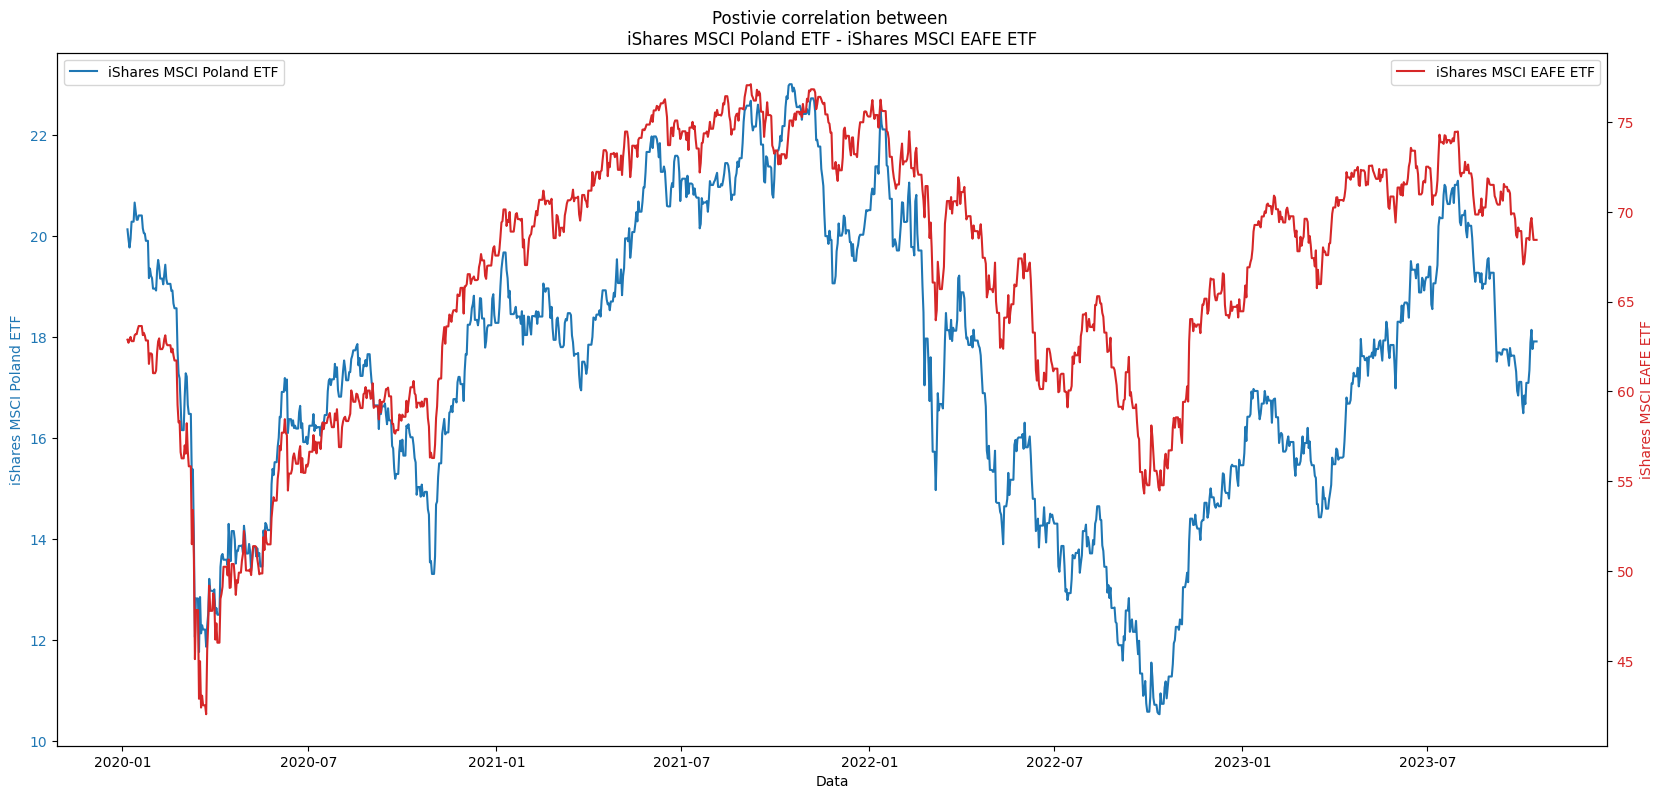

In [26]:
for symbol in top_corr[:5].index:
    fig, ax1 = plt.subplots(figsize=(20, 9))
    
    # first chart
    color = 'tab:blue'
    ax1.set_xlabel('Data')
    ax1.set_ylabel(symbols["EPOL"], color=color)
    ax1.plot(df.index, df["EPOL"], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    # make second axis
    ax2 = ax1.twinx()
    
    # second chart
    color = 'tab:red'
    ax2.set_ylabel(symbols[symbol], color=color)
    ax2.plot(df.index, df[symbol], color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    
    plt.title(f'Postivie correlation between \n{symbols["EPOL"]} - {symbols[symbol]}')
    
    # Add legend for each symbol
    ax1.legend([symbols["EPOL"]], loc='upper left')
    ax2.legend([symbols[symbol]], loc='upper right')
    
    plt.show()

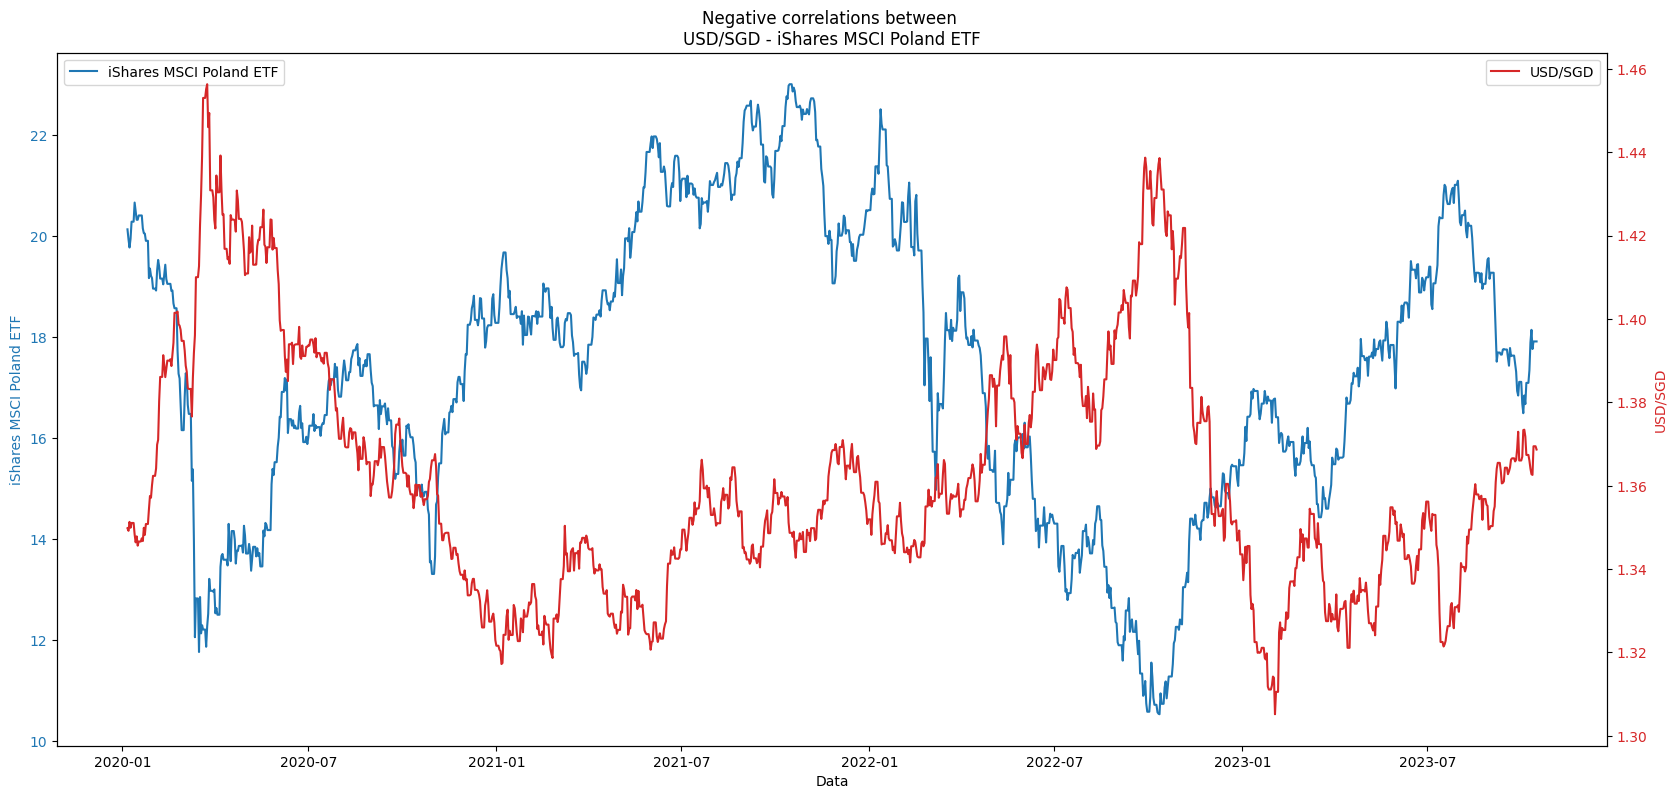

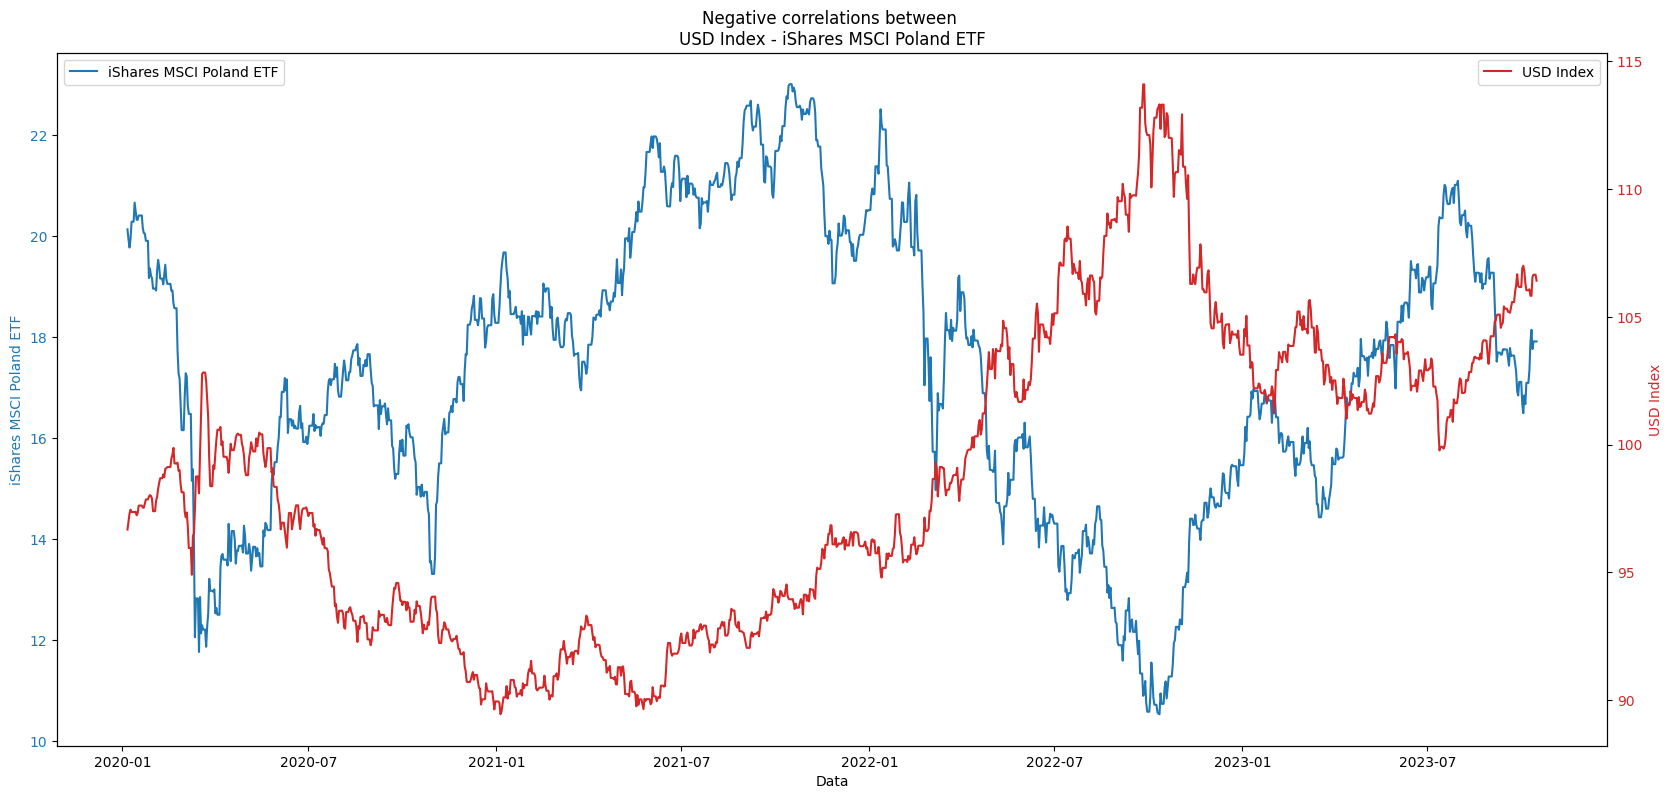

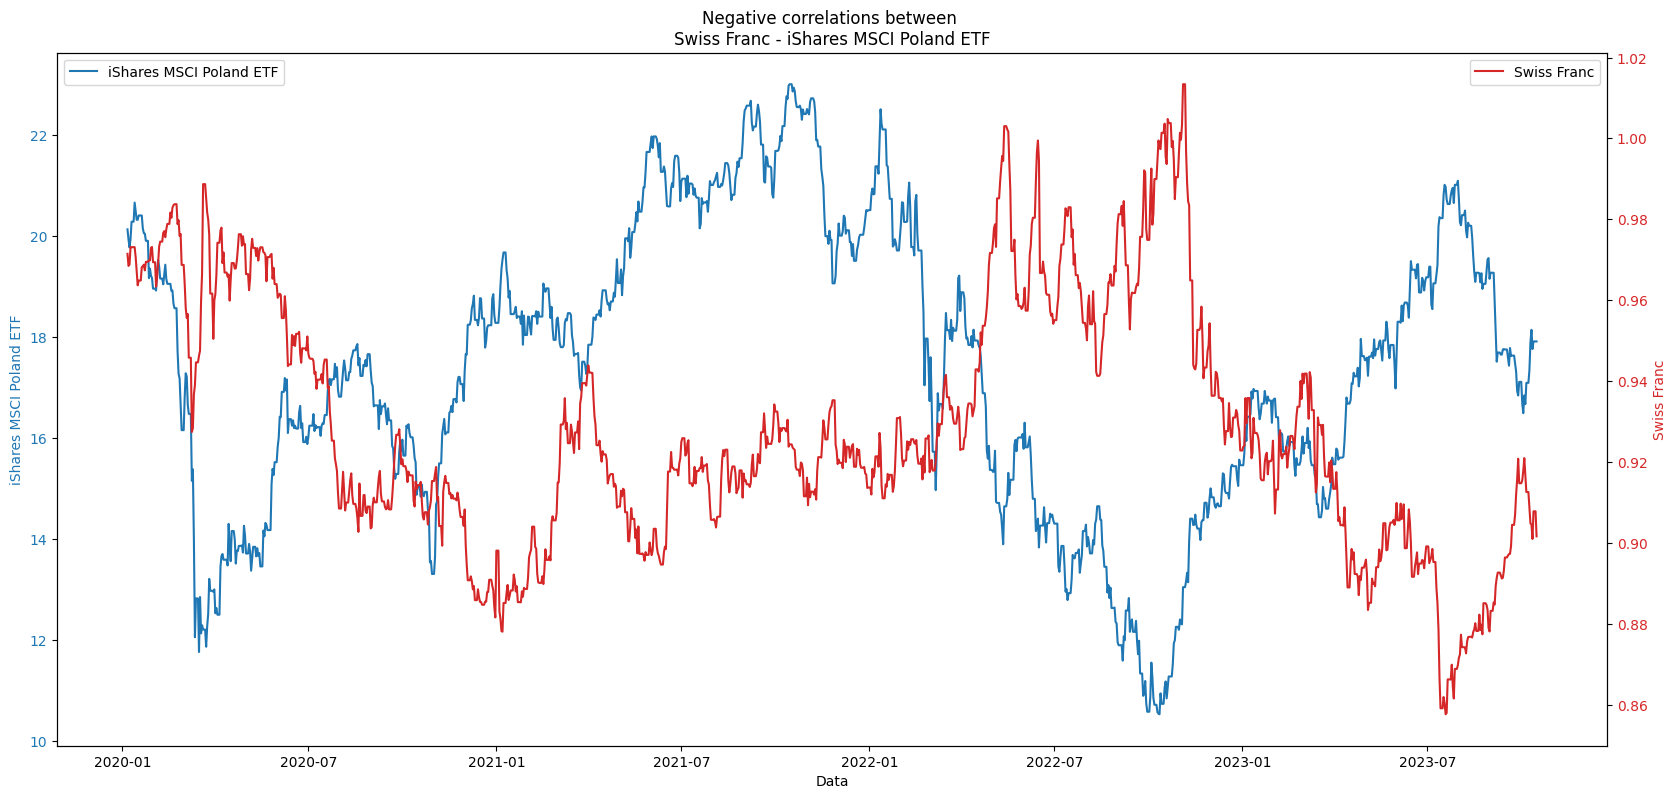

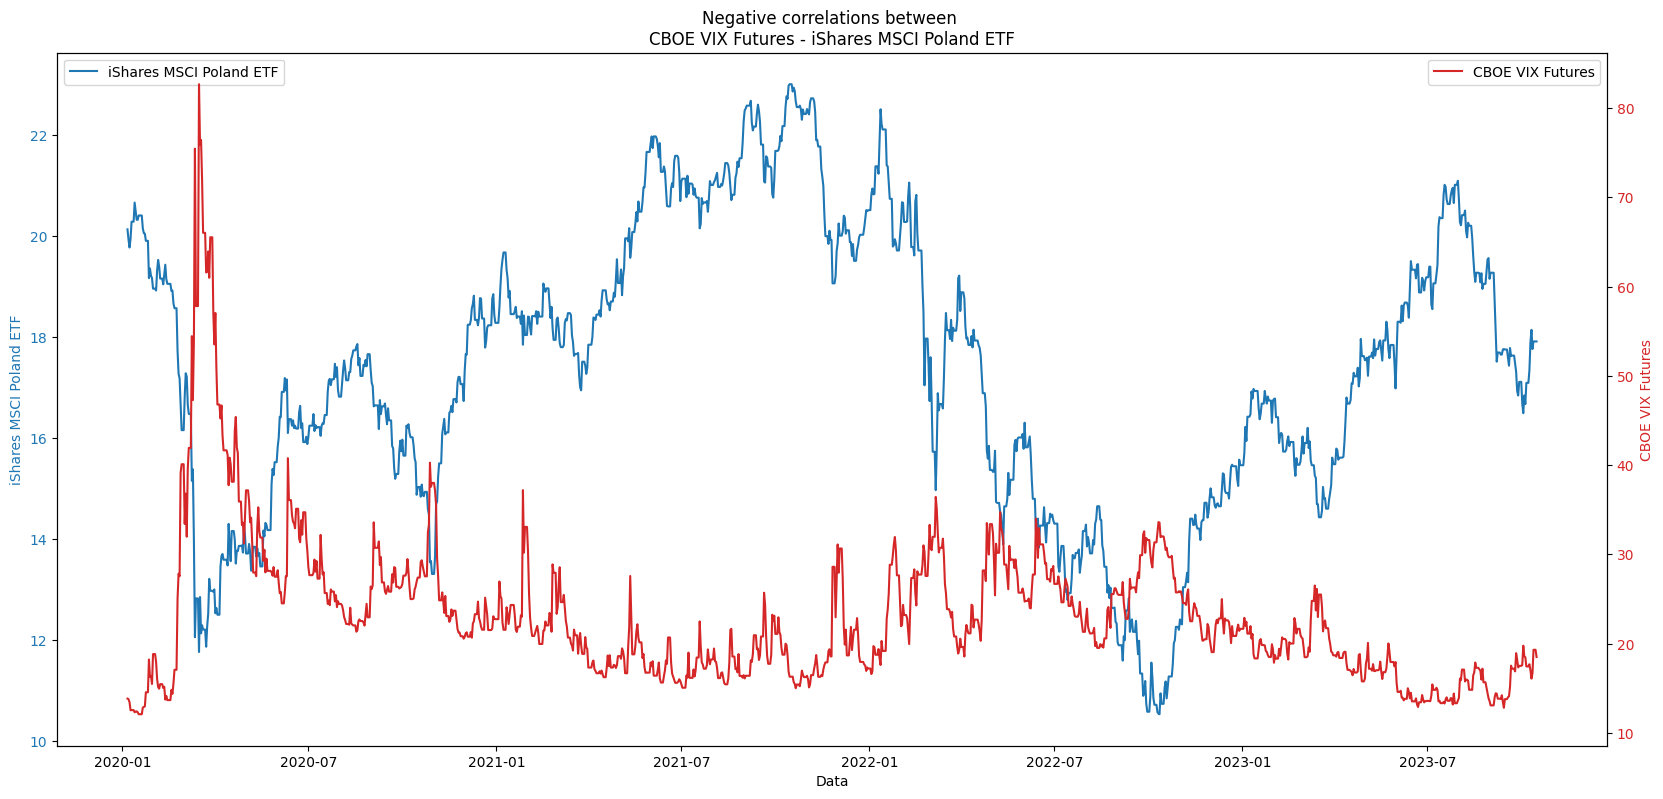

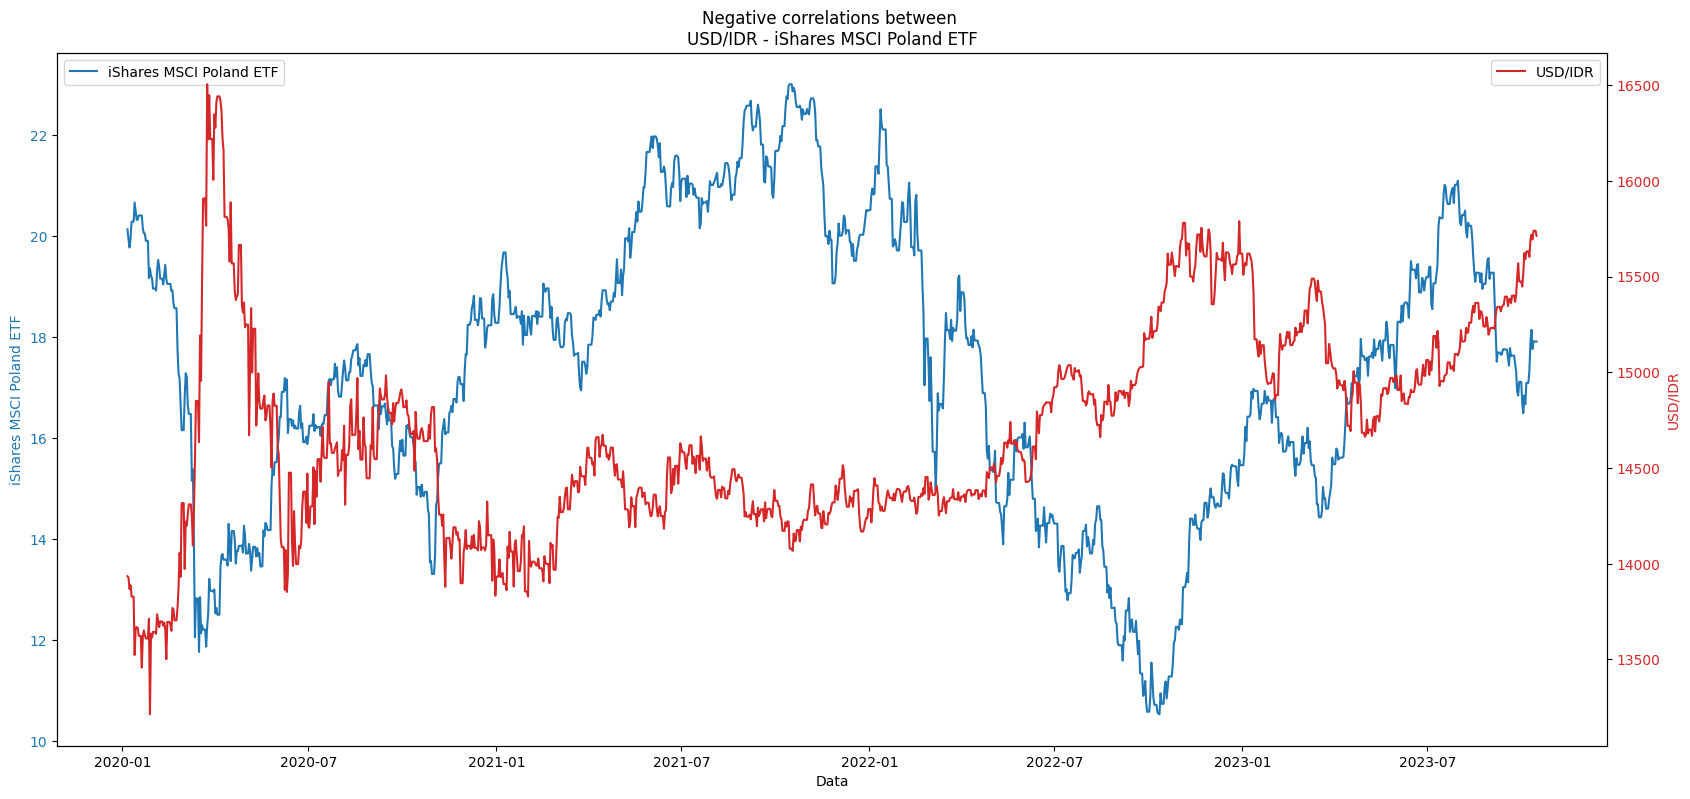

In [27]:
# Inicjalizacja legendy
legend_labels = []

for symbol in bottom_corr[:5].index:
    fig, ax1 = plt.subplots(figsize=(20, 9))
    
    # chart for first symbol
    color = 'tab:blue'
    ax1.set_xlabel('Data')
    ax1.set_ylabel(symbols["EPOL"], color=color)
    ax1.plot(df.index, df["EPOL"], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    #second axis
    ax2 = ax1.twinx()
    
    # second chart
    color = 'tab:red'
    ax2.set_ylabel(symbols[symbol], color=color)
    ax2.plot(df.index, df[symbol], color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    
    plt.title(f'Negative correlations between \n{symbols[symbol]} - {symbols["EPOL"]}')
    
    # legend
    ax1.legend([symbols["EPOL"]], loc='upper left')
    ax2.legend([symbols[symbol]], loc='upper right')
    
    plt.show()

In [28]:
epol_df = yf.download("EPOL")["Adj Close"].to_frame(name="EPOL")

[*********************100%%**********************]  1 of 1 completed


In [29]:
print(epol_df.isnull().any().sum())
epol_df = epol_df.ffill()
epol_df=epol_df.dropna()

0


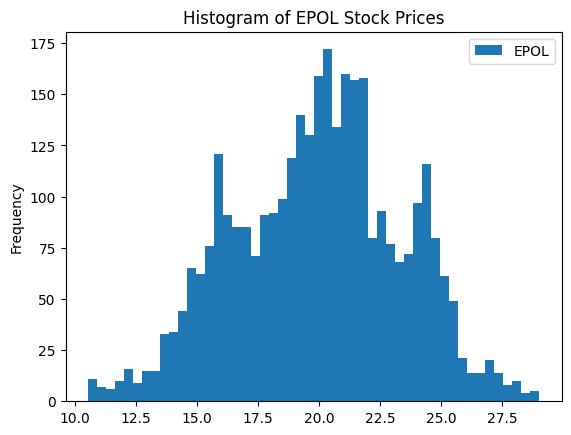

In [30]:
# Create a histogram with 50 bins for the 'EPOL' column
epol_df.plot(kind='hist', bins=50)

# Set a title for the plot
plt.title('Histogram of EPOL Stock Prices')

# Display the plot
plt.show()


We can see how prices are distributed, mainly around 20, and interestingly, big peaks appear around 24 and 16 (this could be border for over and under - valuation of stock)

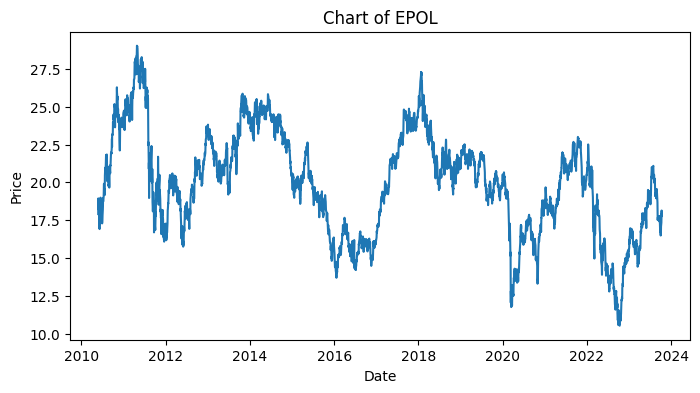

In [31]:
plt.figure(figsize=(8, 4))
plt.plot(epol_df)
plt.title('Chart of EPOL')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [32]:
last_price=epol_df.iloc[-1,0]
print("last price: ",last_price)

last price:  17.90999984741211


It's fair to say we are cheap now, last price is below common value (17.91$)

In [33]:
epol_df.describe()

,EPOL
count,3370.000000
mean,19.960001
std,3.427399
min,10.531733
25%,17.470159
50%,20.143382
75%,22.273170
max,29.024197


Based on this information, the latest value of 17.9 is lower than the mean 19.96 and median 20.14.
It is also below the third quartile (75%) of 22.27 and above the first quartile (25%) of 17.47. This means that price in the last observation is at a level that is between the lower and upper halves of the data in the price distribution. 
That also suggest for that the EPOL share price is currently at a relatively lower level compared to the average or higher price level over the period analyzed.

C:\Users\linkl\AppData\Local\Temp\ipykernel_5444\190911743.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  median = epol_df.median()[0]
C:\Users\linkl\AppData\Local\Temp\ipykernel_5444\190911743.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mean = epol_df.mean()[0]
C:\Users\linkl\AppData\Local\Temp\ipykernel_5444\190911743.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  std_dev = epol_df.std()[0]


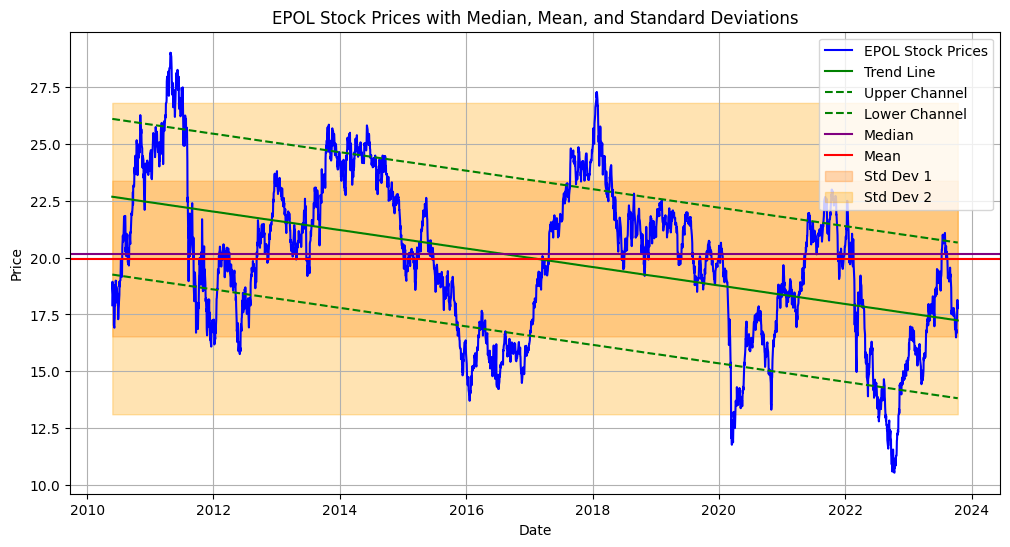

In [34]:
median = epol_df.median()[0]
mean = epol_df.mean()[0]
std_dev = epol_df.std()[0]
std_dev_1 = std_dev
std_dev_2 = 2 * std_dev

prices = epol_df.values.reshape(-1, 1)
dates = np.arange(len(epol_df)).reshape(-1, 1)

# Utwórz model regresji liniowej
model = LinearRegression()
model.fit(dates, prices)

# Oblicz prognozowane wartości na podstawie modelu
trend_line = model.predict(dates)
channel_width =  std_dev
upper_channel = trend_line + channel_width
lower_channel = trend_line - channel_width

# making chart
plt.figure(figsize=(12, 6))
plt.plot(epol_df.index, epol_df, label='EPOL Stock Prices', color='blue')
plt.plot(epol_df.index, trend_line, label='Trend Line', color='green')
# Add upper and lower channel lines to the plot
plt.plot(epol_df.index, upper_channel, label='Upper Channel', color='green', linestyle='--')
plt.plot(epol_df.index, lower_channel, label='Lower Channel', color='green', linestyle='--')

plt.axhline(median, linestyle='-', label='Median', color='purple')
plt.axhline(mean, linestyle='-', label='Mean', color='red')
plt.fill_between(epol_df.index, mean - std_dev_1, mean + std_dev_1, alpha=0.3, label='Std Dev 1', color='tab:orange')
plt.fill_between(epol_df.index, mean - std_dev_2, mean + std_dev_2, alpha=0.3, label='Std Dev 2', color='orange')

plt.title('EPOL Stock Prices with Median, Mean, and Standard Deviations')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


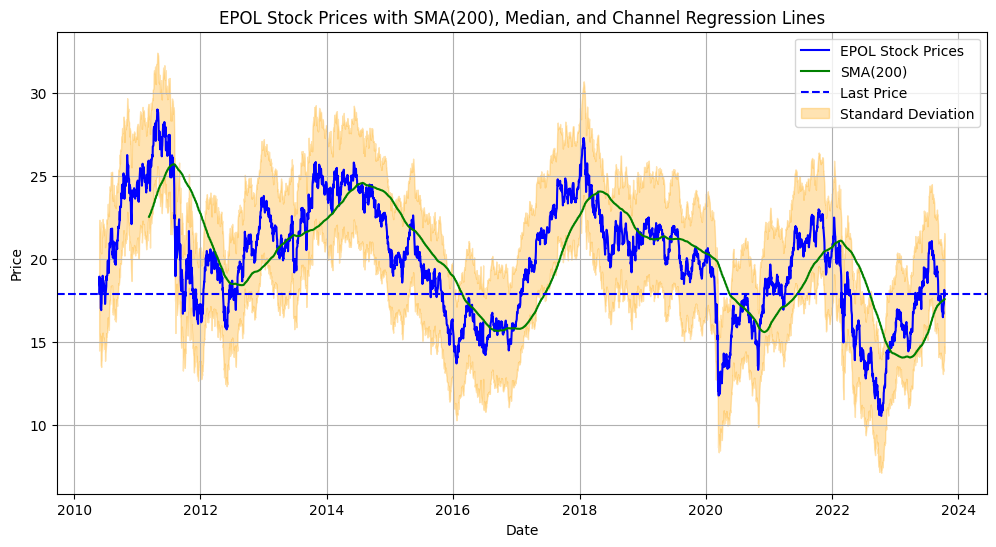

In [35]:
sma200 = epol_df["EPOL"].rolling(window=200).mean()
# Rest of your code remains the same
plt.figure(figsize=(12, 6))
plt.plot(epol_df.index, epol_df["EPOL"], label='EPOL Stock Prices', color='blue')
plt.plot(epol_df.index, sma200, label='SMA(200)', color='green')
plt.axhline(last_price, linestyle='--', label='Last Price' ,color='blue')
plt.fill_between(epol_df.index, epol_df['EPOL'] - std_dev, epol_df['EPOL'] + std_dev, alpha=0.3, label='Standard Deviation', color='orange')
plt.title('EPOL Stock Prices with SMA(200), Median, and Channel Regression Lines')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


15:19:57 - cmdstanpy - INFO - Chain [1] start processing
15:19:58 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\linkl\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\linkl\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
c:\Users\linkl\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:228: FutureWarning: T

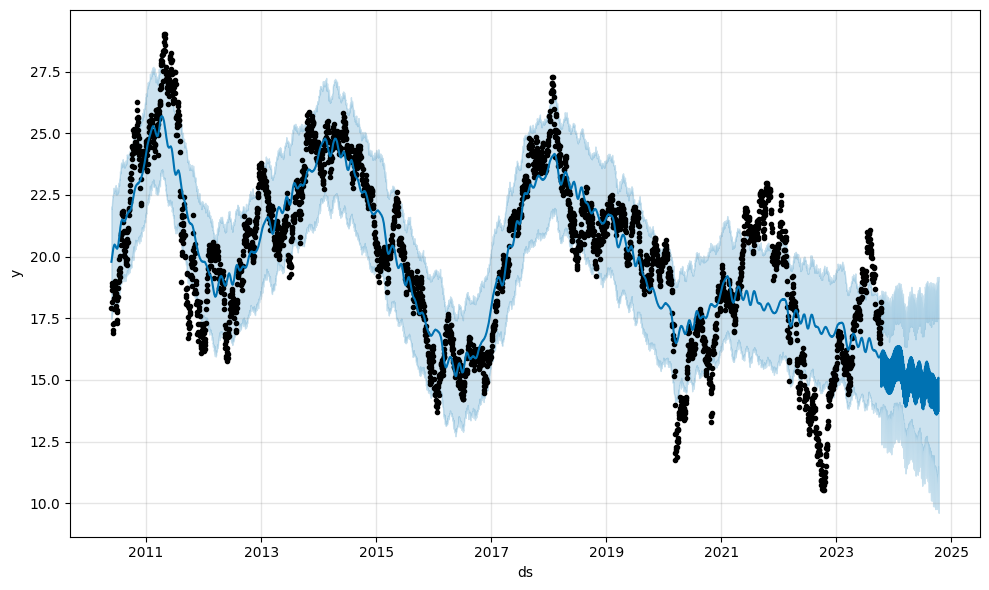

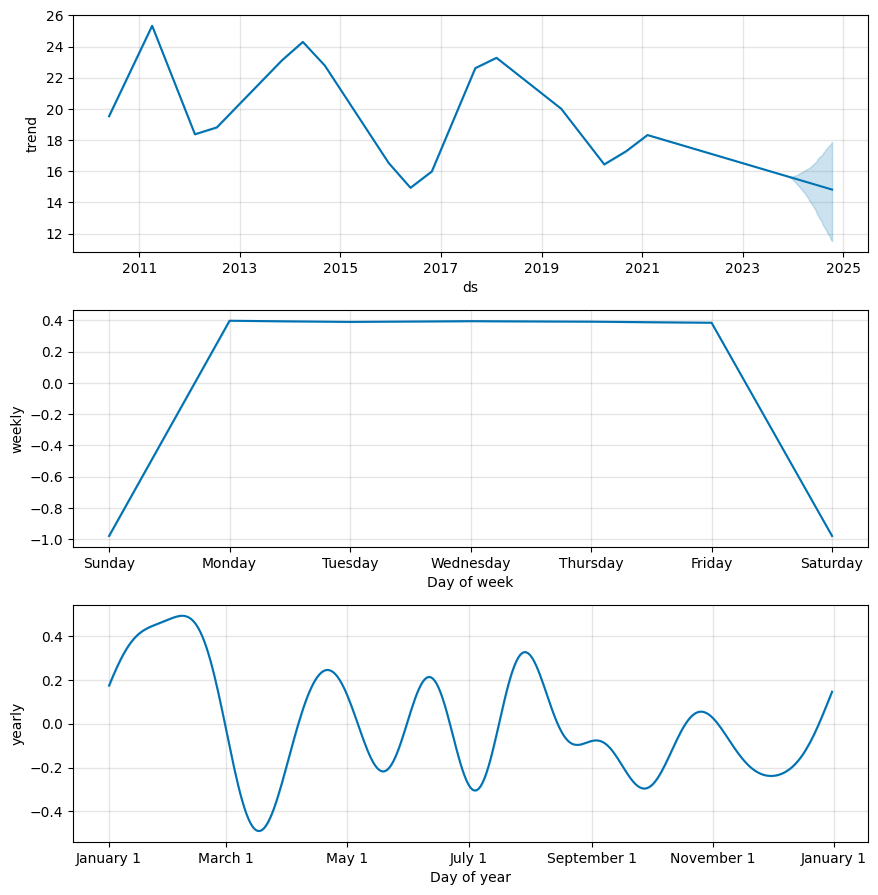

In [36]:
# print(epol_df['EPOL'].values)
data = pd.DataFrame()
data['ds'] = epol_df.index
data['y'] = epol_df['EPOL'].values # Assuming the index contains date information
# Create a Prophet model
model = Prophet()

# Fit the model
model.fit(data)

# Create a dataframe for future predictions
future = model.make_future_dataframe(periods=365)  # You can change the number of days you want to forecast

# Make predictions
forecast = model.predict(future)

# You can access the forecasted values using forecast['yhat']

# To visualize the forecast, you can use the following code
fig = model.plot(forecast)

# To see the components of the forecast, you can use the following code
fig = model.plot_components(forecast)


In [37]:
import statsmodels.api as sm





# Przykładowy DataFrame z danymi o nazwie "epol_df"
# Zakładam, że DataFrame ma kolumny "ds" (daty) i "y" (wartości)
# Upewnij się, że nazwy kolumn w twoim DataFrame są takie same
# Tworzenie przykładowego DataFrame z danymi
data = {
    "ds": pd.date_range(start="2023-01-01", end="2023-12-31", freq="D"),
    "y": range(1, 367)  # Przykładowe wartości, możesz dostosować do swoich danych
}
epol_df = pd.DataFrame(data)

# Odrzuć weekendy z DataFrame
epol_df = epol_df[epol_df["ds"].dt.dayofweek < 5]

# Fit ARIMA model
model = sm.tsa.ARIMA(epol_df["y"], order=(5,1,0))  # You can adjust the order as needed
results = model.fit()

# Generate future dates (excluding weekends)
future_dates = pd.date_range(start="2023-01-01", end="2024-01-01", freq="D")
future_dates = future_dates[future_dates.to_series().dt.dayofweek < 5]

# Make predictions
forecast, stderr, conf_int = results.forecast(steps=len(future_dates))

# Create a DataFrame for the forecast
forecast_df = pd.DataFrame({
    "ds": future_dates,
    "y": forecast
})

# Visualize the forecast
plt.figure(figsize=(12, 6))
plt.plot(epol_df["ds"], epol_df["y"], label="Observed Data", color="blue")
plt.plot(forecast_df["ds"], forecast_df["y"], label="ARIMA Forecast", color="red")
plt.fill_between(forecast_df["ds"], conf_int[:, 0], conf_int[:, 1], color="pink", alpha=0.5)
plt.title("ARIMA Forecast")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.show()


ValueError: All arrays must be of the same length